<a href="https://colab.research.google.com/github/leodan52/Robot_Trading_Challenge/blob/main/notebook/Robot_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Robot Trading - Challenge BootCamp Data Science Alura

## 1. Configuración del ambiente

Declarando variables globales

In [33]:
global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

Importando librerias principales

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Importando librerías secundarias

In [35]:
import yfinance as yf
from bs4 import BeautifulSoup
import requests
import re
from datetime import datetime, timedelta

## 2. Obtención de datos

In [36]:
def importar_base_bitcoin():

  ''' Importa el historico de los precios del BitCoin de los últimos 7 días en intervalos de 5 minutos'''

  global df_bitcoin

  end_day = datetime.today()
  period = timedelta(days = 7)
  start_day = end_day - period

  ticker = yf.Ticker('BTC-USD')

  df_bitcoin = ticker.history(start = start_day, end = end_day, interval = '5m')

def extraer_tendencias():

  ''' Extrae el precio actual y la tendencia a la 'baja' o a la 'alta' del BitCoin'''

  global precio_actual, tendencia

  headers = {'User-Agent' : 'Mozilla/5.0 (X11; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/118.0'}
  url = 'https://coinmarketcap.com/'

  respuesta = requests.get(url, headers)
  soup = BeautifulSoup(respuesta.content, features = 'lxml')

  filas = soup.find_all('tr')

  for f in filas:
    names = f.findAll('p', {'class' : "sc-4984dd93-0 kKpPOn"})
    actual_prices = f.findAll('div', {'class' : "sc-a0353bbc-0 gDrtaY"})
    tendencias = f.findAll('span', {'class' : "sc-d55c02b-0"})

    if not (len(names) == 1 and len(actual_prices) == 1 and len(tendencias) == 3):
      continue

    dict_datos = procesar(names[0], actual_prices[0], tendencias)

    if 'Bitcoin' in dict_datos:
      break

  precio_actual = dict_datos['Bitcoin']['precio_actual']
  tendencia = dict_datos['Bitcoin']['tendencia1h']

def procesar(nombre, precio_actual, tendencias) -> dict:

  clase_tendencia = {
      'icon-Caret-down' : 'baja',
      'icon-Caret-up' : 'alta'
  }
  salida = {
      nombre.text : {
      'precio_actual' : float(re.sub('[$,]', '', precio_actual.text)),
      'tendencia1h' : clase_tendencia[tendencias[0].span['class'][0]],
      'tendencia24h' : clase_tendencia[tendencias[1].span['class'][0]],
      'tendencia7d' : clase_tendencia[tendencias[2].span['class'][0]]
    }
  }

  return salida

In [37]:
help(importar_base_bitcoin)

Help on function importar_base_bitcoin in module __main__:

importar_base_bitcoin()
    Importa el historico de los precios del BitCoin de los últimos 7 días en intervalos de 5 minutos



In [38]:
help(extraer_tendencias)

Help on function extraer_tendencias in module __main__:

extraer_tendencias()
    Extrae el precio actual y la tendencia a la 'baja' o a la 'alta' del BitCoin



## 3. Limpieza de datos

In [39]:
importar_base_bitcoin()

df_bitcoin

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-27 01:35:00+00:00,33992.042969,34003.738281,33992.042969,34003.738281,0,0.0,0.0
2023-10-27 01:40:00+00:00,33999.062500,34003.007812,33996.562500,33996.562500,0,0.0,0.0
2023-10-27 01:45:00+00:00,33996.035156,33996.035156,33905.578125,33946.894531,0,0.0,0.0
2023-10-27 01:50:00+00:00,33927.367188,33927.367188,33835.441406,33835.441406,22906880,0.0,0.0
2023-10-27 01:55:00+00:00,33797.132812,33872.480469,33797.132812,33856.820312,56416256,0.0,0.0
...,...,...,...,...,...,...,...
2023-11-03 01:15:00+00:00,34559.785156,34559.785156,34408.449219,34408.449219,51177472,0.0,0.0
2023-11-03 01:20:00+00:00,34410.925781,34488.722656,34410.925781,34488.722656,17328128,0.0,0.0
2023-11-03 01:25:00+00:00,34529.531250,34574.675781,34529.531250,34574.675781,40380416,0.0,0.0


In [40]:
def limpieza_datos():
  global df_bitcoin, media_bitcoin

  # Crear un duplicado
  df_bitcoin_limpio = df_bitcoin.copy()

  # Tratar duplicados en el índice (Datetime)

  df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio.index.duplicated()]

  #  Valores nulos en Close

  df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio.Close.notna()]

  # Valores de Volume mayores a 0

  df_bitcoin_limpio = df_bitcoin_limpio.query('Volume > 0')
  df_bitcoin_limpio

  # Eliminar outliers

  Q1 = df_bitcoin_limpio.Close.quantile(0.25)
  Q3 = df_bitcoin_limpio.Close.quantile(0.75)
  IQR = Q3 - Q1
  min_close = Q1 - 1.5 * IQR
  max_close = Q3 + 1.5 * IQR

  df_bitcoin_limpio = df_bitcoin_limpio.query('Close >= @min_close & Close <= @max_close')

  # Promedio de los datos de Close entre Q1 y Q3
  media_bitcoin = df_bitcoin_limpio.query('Close >= @Q1 & Close <= @Q3').Close.mean()

## 4. Tomar decisiones

In [41]:
limpieza_datos()
extraer_tendencias()

In [42]:
def tomar_decisiones():
  global precio_actual, tendencia, media_bitcoin, algoritmo_decision

  if precio_actual >= media_bitcoin and tendencia == 'baja':
    algoritmo_decision = 'Vender'
  elif precio_actual < media_bitcoin and tendencia == 'alta':
    algoritmo_decision = 'comprar'
  else:
    algoritmo_decision = ''

## 5. Visualización

In [43]:
def visualizacion():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

  df_bitcoin['Promedio'] = media_bitcoin

  color_legend = {
      'baja' : 'r',
      'alta' : 'g'
  }

  plt.figure(figsize = (16, 5))
  plt.title('Histórico de los últimos 7 días del Bitcoin (USD)')
  sns.lineplot(data = df_bitcoin[['Close', 'Promedio']], palette = {'Close' : 'b', 'Promedio' : 'r'})
  plt.annotate(f'A la {tendencia}', (df_bitcoin.index.max(), df_bitcoin.tail(1).Close), color = color_legend[tendencia])
  plt.show()

## 6. Automatización

In [44]:
from IPython.display import clear_output
import time

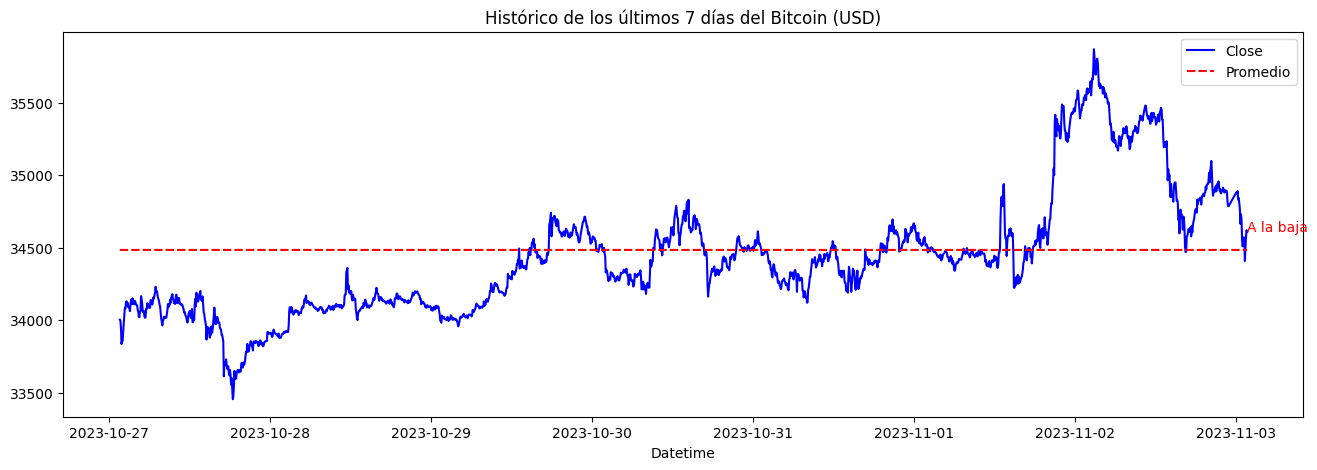

KeyboardInterrupt: ignored

In [45]:
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)